In [1]:
%matplotlib inline
#!pip install imblearn  ## UNCOMMENT when running for the first time
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, make_scorer

pd.set_option('display.max_columns',25)  # to show all the columns while printing the df
pd.set_option('display.max_rows',25)  # to show all the rows while printing the df

### Load the data

In [2]:
data = pd.read_csv("YourCabs.csv")
data.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,01-01-2013 02:00,0,0,01-01-2013 01:39,12.924150,77.672290,12.927320,77.635750,0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 02:25,12.966910,77.749350,12.927680,77.626640,0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,01-01-2013 03:30,0,0,01-01-2013 03:08,12.937222,77.626915,13.047926,77.597766,0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,01-01-2013 05:45,0,0,01-01-2013 04:39,12.989990,77.553320,12.971430,77.639140,0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 07:53,12.845653,77.677925,12.954340,77.600720,0


### Verify the data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   43431 non-null  int64  
 1   user_id              43431 non-null  int64  
 2   vehicle_model_id     43431 non-null  int64  
 3   package_id           7550 non-null   float64
 4   travel_type_id       43431 non-null  int64  
 5   from_area_id         43343 non-null  float64
 6   to_area_id           34293 non-null  float64
 7   from_city_id         16345 non-null  float64
 8   to_city_id           1588 non-null   float64
 9   from_date            43431 non-null  object 
 10  online_booking       43431 non-null  int64  
 11  mobile_site_booking  43431 non-null  int64  
 12  booking_created      43431 non-null  object 
 13  from_lat             43338 non-null  float64
 14  from_long            43338 non-null  float64
 15  to_lat               34293 non-null 

### Dropping columns having unique values and PII

In [4]:
data=data.drop(['id','user_id'],axis=1)

### Filtering out travel_type_id=3

In [5]:
data_tt3 = data[data['travel_type_id'] == 3] # filtering the data having travel_type_id 3
data_tt3.head()

,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
8,65,2.0,3,448.0,NaN,NaN,NaN,01-01-2013 16:00,0,0,01-01-2013 09:44,12.927320,77.635750,NaN,NaN,0
20,87,2.0,3,471.0,NaN,NaN,NaN,01-01-2013 14:30,0,0,01-01-2013 12:52,13.018540,77.635240,NaN,NaN,0
23,12,1.0,3,1286.0,NaN,NaN,NaN,01-01-2013 16:30,0,0,01-01-2013 14:39,12.973448,77.620320,NaN,NaN,0
34,12,1.0,3,1323.0,NaN,NaN,NaN,01-01-2013 20:00,1,0,01-01-2013 17:25,12.869805,77.653211,NaN,NaN,0
47,12,2.0,3,142.0,NaN,NaN,NaN,01-02-2013 03:00,0,0,01-01-2013 19:37,12.912810,77.609230,NaN,NaN,0


### Dropping travel_type_id which is no more required

In [6]:
data_tt2 = data_tt3.drop(['travel_type_id'],axis=1)

### Checking missing values

In [7]:
data_tt3.shape

(7550, 16)

In [8]:
data_tt3.isnull().sum()

vehicle_model_id          0
package_id                0
travel_type_id            0
from_area_id              0
to_area_id             7550
from_city_id           7102
to_city_id             7550
from_date                 0
online_booking            0
mobile_site_booking       0
booking_created           0
from_lat                  0
from_long                 0
to_lat                 7550
to_long                7550
Car_Cancellation          0
dtype: int64

### Analysing data proportion in categorical variables

In [9]:
data_tt3['vehicle_model_id'].value_counts(normalize=True)*100

12    72.794702
65     8.794702
89     4.397351
85     4.079470
87     3.284768
28     2.980132
24     1.933775
23     0.463576
86     0.251656
90     0.238411
10     0.185430
17     0.172185
30     0.172185
36     0.079470
64     0.079470
43     0.026490
72     0.026490
76     0.013245
75     0.013245
39     0.013245
Name: vehicle_model_id, dtype: float64

In [10]:
data_tt3['package_id'].value_counts(normalize=True)*100

1.0    46.397351
2.0    35.112583
6.0     6.649007
4.0     5.456954
3.0     4.966887
7.0     1.337748
5.0     0.079470
Name: package_id, dtype: float64

In [11]:
data_tt3['from_area_id'].value_counts(normalize=True)*100

571.0     4.437086
293.0     3.443709
393.0     2.993377
1010.0    2.516556
58.0      1.801325
            ...   
802.0     0.013245
1370.0    0.013245
1117.0    0.013245
1080.0    0.013245
328.0     0.013245
Name: from_area_id, Length: 482, dtype: float64

In [12]:
data_tt3['to_area_id'].value_counts(normalize=True)*100

Series([], Name: to_area_id, dtype: float64)

In [13]:
data_tt3['from_city_id'].value_counts(normalize=True)*100

15.0    100.0
Name: from_city_id, dtype: float64

In [14]:
data_tt3['to_city_id'].value_counts(normalize=True)*100

Series([], Name: to_city_id, dtype: float64)

In [15]:
data_tt3['online_booking'].value_counts(normalize=True)*100

0    71.642384
1    28.357616
Name: online_booking, dtype: float64

In [16]:
data_tt3['mobile_site_booking'].value_counts(normalize=True)*100

0    97.364238
1     2.635762
Name: mobile_site_booking, dtype: float64

#### Deleting vehicle_model_id, package_id, mobile_site_booking, from_city_id,to_city_id columns

In [17]:
### Delete the below columns due to:
### vehicle_model_id - improportionate data, leads to bias
### to_area_id - not required for travel_type_id = 3
### from_city_id- improportionate data, leads to bias
### to_city_id - not required for travel_type_id = 3
### mobile_site_booking - improportionate data, leads to bias
### from_lat, from_long - same information as in from_area_id
### to_lat, to_long - null values and also not mandatory for travel_type_id = 3

data_tt3 = data_tt3.drop(['vehicle_model_id','to_area_id','from_city_id','to_city_id','from_lat','from_long','to_lat','to_long','mobile_site_booking'],axis=1)
data_tt3.head()

,package_id,travel_type_id,from_area_id,from_date,online_booking,booking_created,Car_Cancellation
8,2.0,3,448.0,01-01-2013 16:00,0,01-01-2013 09:44,0
20,2.0,3,471.0,01-01-2013 14:30,0,01-01-2013 12:52,0
23,1.0,3,1286.0,01-01-2013 16:30,0,01-01-2013 14:39,0
34,1.0,3,1323.0,01-01-2013 20:00,1,01-01-2013 17:25,0
47,2.0,3,142.0,01-02-2013 03:00,0,01-01-2013 19:37,0


### Treating and extracting info from Date columns

In [18]:
data_tt3['from_date_treated'] = pd.to_datetime(data_tt3['from_date'])
data_tt3['booking_date_treated'] = pd.to_datetime(data_tt3['booking_created'])
data_tt3.head()

,package_id,travel_type_id,from_area_id,from_date,online_booking,booking_created,Car_Cancellation,from_date_treated,booking_date_treated
8,2.0,3,448.0,01-01-2013 16:00,0,01-01-2013 09:44,0,2013-01-01 16:00:00,2013-01-01 09:44:00
20,2.0,3,471.0,01-01-2013 14:30,0,01-01-2013 12:52,0,2013-01-01 14:30:00,2013-01-01 12:52:00
23,1.0,3,1286.0,01-01-2013 16:30,0,01-01-2013 14:39,0,2013-01-01 16:30:00,2013-01-01 14:39:00
34,1.0,3,1323.0,01-01-2013 20:00,1,01-01-2013 17:25,0,2013-01-01 20:00:00,2013-01-01 17:25:00
47,2.0,3,142.0,01-02-2013 03:00,0,01-01-2013 19:37,0,2013-01-02 03:00:00,2013-01-01 19:37:00


In [19]:
# After extracting required info in required format from date columns dropping the actual date columns in the data
data_tt3 = data_tt3.drop(['from_date','booking_created'],axis=1)

#### Creating new columns from given date columns

In [20]:
data_tt3['waiting_period_min'] = (data_tt3['from_date_treated'] - data_tt3['booking_date_treated']).astype('timedelta64[m]') #new column waiting_period_min

data_tt3['travel_day'] = pd.to_datetime(data_tt3['from_date_treated']).dt.dayofweek #new column travel_day
data_tt3['travel_month'] = pd.to_datetime(data_tt3['from_date_treated']).dt.month #new column travel_month
data_tt3['booked_day'] = pd.to_datetime(data_tt3['booking_date_treated']).dt.dayofweek #new column booked_day
data_tt3['booked_month'] = pd.to_datetime(data_tt3['booking_date_treated']).dt.month #new column booked_month

cond = [(pd.to_datetime(data_tt3['from_date_treated']).dt.hour.between(5, 8)),
        (pd.to_datetime(data_tt3['from_date_treated']).dt.hour.between(9, 12)),
        (pd.to_datetime(data_tt3['from_date_treated']).dt.hour.between(13, 16)),
        (pd.to_datetime(data_tt3['from_date_treated']).dt.hour.between(17, 20)),
        ((pd.to_datetime(data_tt3['from_date_treated']).dt.hour.between(21, 24)) | (pd.to_datetime(data_tt3['from_date_treated']).dt.hour==0)),
        (pd.to_datetime(data_tt3['from_date_treated']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']

data_tt3['travel_hour'] = np.select(cond,values) #new column travel_hour


cond = [(pd.to_datetime(data_tt3['booking_date_treated']).dt.hour.between(5, 8)),
        (pd.to_datetime(data_tt3['booking_date_treated']).dt.hour.between(9, 12)),
        (pd.to_datetime(data_tt3['booking_date_treated']).dt.hour.between(13, 16)),
        (pd.to_datetime(data_tt3['booking_date_treated']).dt.hour.between(17, 20)),
        ((pd.to_datetime(data_tt3['booking_date_treated']).dt.hour.between(21, 24)) | (pd.to_datetime(data_tt3['booking_date_treated']).dt.hour==0)),
        (pd.to_datetime(data_tt3['booking_date_treated']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']

data_tt3['booked_hour'] = np.select(cond,values) #new column booked_hour

data_tt3.head()

,package_id,travel_type_id,from_area_id,online_booking,Car_Cancellation,from_date_treated,booking_date_treated,waiting_period_min,travel_day,travel_month,booked_day,booked_month,travel_hour,booked_hour
8,2.0,3,448.0,0,0,2013-01-01 16:00:00,2013-01-01 09:44:00,376.0,1,1,1,1,Afternoon,Morning
20,2.0,3,471.0,0,0,2013-01-01 14:30:00,2013-01-01 12:52:00,98.0,1,1,1,1,Afternoon,Morning
23,1.0,3,1286.0,0,0,2013-01-01 16:30:00,2013-01-01 14:39:00,111.0,1,1,1,1,Afternoon,Afternoon
34,1.0,3,1323.0,1,0,2013-01-01 20:00:00,2013-01-01 17:25:00,155.0,1,1,1,1,Evening,Evening
47,2.0,3,142.0,0,0,2013-01-02 03:00:00,2013-01-01 19:37:00,443.0,2,1,1,1,Late Night,Evening


### Checking missing values in the newly created columns

In [21]:
data_tt3.isnull().sum()

package_id              0
travel_type_id          0
from_area_id            0
online_booking          0
Car_Cancellation        0
from_date_treated       0
booking_date_treated    0
waiting_period_min      0
travel_day              0
travel_month            0
booked_day              0
booked_month            0
travel_hour             0
booked_hour             0
dtype: int64

### Drop date cols

In [22]:
### Now that required info has been extracted from date, lat, long columns and new cols created, those cols can be deleted
data_tt3=data_tt3.drop(['from_date_treated','booking_date_treated'],axis=1)

### Analysing data proportion in newly created categorical variables

In [23]:
data_tt3['travel_month'].value_counts(normalize=True)*100

9     12.264901
10    11.470199
8     11.311258
5     10.741722
6     10.582781
7      9.841060
11     7.390728
4      7.125828
3      7.019868
2      6.158940
1      6.092715
Name: travel_month, dtype: float64

In [24]:
data_tt3['booked_month'].value_counts(normalize=True)*100

9     12.172185
8     11.576159
10    11.483444
5     10.701987
6     10.476821
7      9.880795
4      7.245033
11     7.059603
3      7.006623
1      6.211921
2      6.185430
Name: booked_month, dtype: float64

In [25]:
data_tt3['booked_day'].value_counts(normalize=True)*100

5    19.192053
6    16.847682
4    14.913907
3    12.675497
2    12.582781
0    11.920530
1    11.867550
Name: booked_day, dtype: float64

In [26]:
data_tt3['travel_day'].value_counts(normalize=True)*100

5    19.417219
6    18.423841
4    13.350993
2    13.006623
3    12.238411
0    11.894040
1    11.668874
Name: travel_day, dtype: float64

In [27]:
data_tt3['travel_hour'].value_counts(normalize=True)*100

Morning          38.569536
Afternoon        21.880795
Early Morning    18.860927
Evening          14.463576
Late Night        3.364238
Night             2.860927
Name: travel_hour, dtype: float64

In [28]:
data_tt3['booked_hour'].value_counts(normalize=True)*100

Morning          30.238411
Afternoon        21.933775
Evening          18.622517
Night            16.847682
Early Morning    10.635762
Late Night        1.721854
Name: booked_hour, dtype: float64

### Looking for outliers if any in newly created conitnuous variable columns

In [29]:
def find_outliers_IQR(df):  ### function to find outliers using IQR method
    LL,UL = find_LL_UL(df)
    outliers = df[((df < LL) | (df > UL))]
    return outliers

def find_LL_UL(df):         ### function to find lower limit and upper limit values in the given data using IQR method
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    LL = q1 - 1.5 * IQR
    UL = q3 + 1.5 * IQR
    return (LL,UL)

##### outliers in waiting_period_min

<Axes: xlabel='waiting_period_min'>

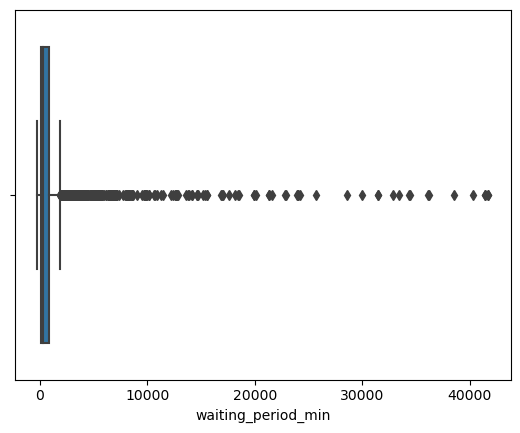

In [30]:
sns.boxplot(data=data_tt3, x='waiting_period_min') #Before treatment

In [31]:
### Find the percentage of outliers in waiting_period_min column
outliers = find_outliers_IQR(data_tt3['waiting_period_min'])
print("Number of Outliers in Waiting Period : ",outliers.shape[0])
print("Percentage of outliers in Waiting Period : ", (outliers.shape[0]/data_tt3.shape[0])*100)

Number of Outliers in Waiting Period :  612
Percentage of outliers in Waiting Period :  8.105960264900663


In [32]:
### Negative values in waiting_period_min are due to wrong data in from_date and booked_date, so dropping the respective data
print("Negative values in waiting_period_min - Before treatment : ",(data_tt3['waiting_period_min'] < 0).value_counts())

data_tt3.drop(data_tt3[data_tt3['waiting_period_min']<0].index,axis=0,inplace=True)

print("Negative values in waiting_period_min - After treatment : ",(data_tt3['waiting_period_min'] < 0).value_counts())

Negative values in waiting_period_min - Before treatment :  False    7536
True       14
Name: waiting_period_min, dtype: int64
Negative values in waiting_period_min - After treatment :  False    7536
Name: waiting_period_min, dtype: int64


In [33]:
##### outlier treatment for waiting_period_min

In [34]:
### print("Outliers in waiting_period_min on the lower end before treatment: ",(data_tt3['waiting_period_min'] < 0).value_counts())

### LL,UL = find_LL_UL(data_tt3['waiting_period_min'])
### print("Outliers in waiting_period_min on the higher end before treatment: ",(data_tt3['waiting_period_min'] > UL).value_counts())

In [35]:
### Negative values in waiting_period_min are due to wrong data in from_date and booked_date, so dropping the respective data
### data_tt3.drop(data_tt3[data_tt3['waiting_period_min']<0].index,axis=0,inplace=True)
### print("Outliers in waiting_period_min on the lower end after treatment: ",(data_tt3['waiting_period_min'] < 0).value_counts()) ### Outliers on the lower end after treatment

In [36]:
### Outliers in waiting_period_min on the higher side more than 13%, so splitting data into with outliers and without outliers
### to build 2 models
### LL,UL = find_LL_UL(data_tt3['waiting_period_min'])
### data_tt3_wpol = data_tt3[data_tt3['waiting_period_min'] > UL] ### Data with outliers in waiting_period_min
### data_tt3 = data_tt3.drop(data_tt3[data_tt3['waiting_period_min']>UL].index,axis=0,inplace=True) ### Removing the outliers to get data without outliers in waiting_period_min

In [37]:
### sns.boxplot(data_tt3['waiting_period_min']) #After treatment

###### NOTE : Outliers for the remaining data in waiting_period_min would appear iteratively, so transformation and normalisation of the data is required rather to treat outliers

### Transformation of waiting_period_min using cbrt

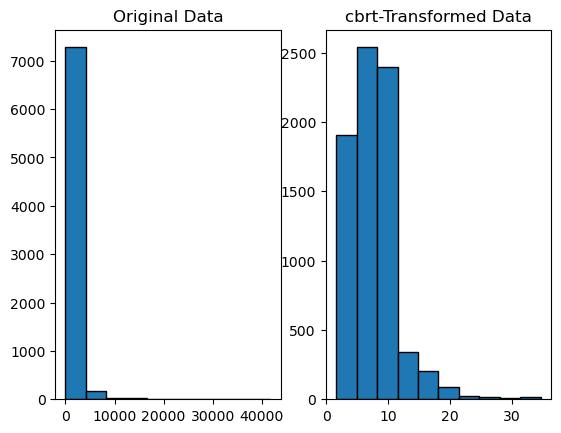

In [38]:
data = data_tt3['waiting_period_min']

# Perform cbrt transformation
data_log = np.cbrt(data)

# Create side-by-side histograms
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].hist(data, edgecolor='black')
axs[1].hist(data_log, edgecolor='black')
axs[0].set_title('Original Data')
axs[1].set_title('cbrt-Transformed Data')
plt.show()

In [39]:
data_tt3['waiting_period_min'] = data_log ### replace actual data with transformed data

<Axes: xlabel='waiting_period_min'>

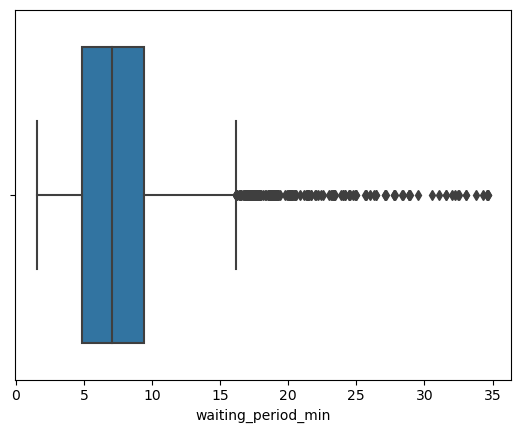

In [40]:
sns.boxplot(data=data_tt3, x='waiting_period_min') ### before treatment after transformation

In [41]:
### Find the percentage of outliers in waiting_period_min column
outliers = find_outliers_IQR(data_tt3['waiting_period_min'])
print("Number of Outliers in Waiting Period : ",outliers.shape[0])
print("Percentage of outliers in Waiting Period : ", (outliers.shape[0]/data_tt3.shape[0])*100)

Number of Outliers in Waiting Period :  252
Percentage of outliers in Waiting Period :  3.343949044585987


###### Outliers in waiting_period_min are >5% but <10%. So, replacing it with respective limit values

In [42]:
### Percentage of outliers in the data is  less than 5%
### Outliers are only on the max side of the data, so replacing Outliers with Upper limit value

LL,UL = find_LL_UL(data_tt3['waiting_period_min'])
print("Lower limit and Upper limit values: ",LL,UL)

data_tt3.loc[data_tt3['waiting_period_min'] > UL,'waiting_period_min'] = UL

Lower limit and Upper limit values:  -1.8871926865913133 16.150651707181026


<Axes: xlabel='waiting_period_min'>

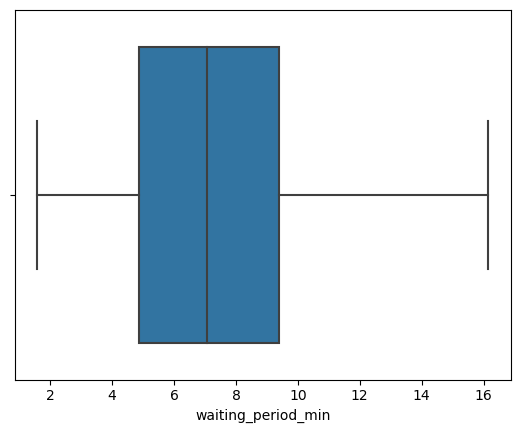

In [43]:
sns.boxplot(data=data_tt3, x='waiting_period_min') # after treatment after transformation

### Verify the pre processed data

In [44]:
data_tt3.shape

(7536, 12)

In [45]:
data_tt3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7536 entries, 8 to 43428
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   package_id          7536 non-null   float64
 1   travel_type_id      7536 non-null   int64  
 2   from_area_id        7536 non-null   float64
 3   online_booking      7536 non-null   int64  
 4   Car_Cancellation    7536 non-null   int64  
 5   waiting_period_min  7536 non-null   float64
 6   travel_day          7536 non-null   int64  
 7   travel_month        7536 non-null   int64  
 8   booked_day          7536 non-null   int64  
 9   booked_month        7536 non-null   int64  
 10  travel_hour         7536 non-null   object 
 11  booked_hour         7536 non-null   object 
dtypes: float64(3), int64(7), object(2)
memory usage: 765.4+ KB


In [46]:
data_tt3.isnull().sum()

package_id            0
travel_type_id        0
from_area_id          0
online_booking        0
Car_Cancellation      0
waiting_period_min    0
travel_day            0
travel_month          0
booked_day            0
booked_month          0
travel_hour           0
booked_hour           0
dtype: int64

In [47]:
data_tt3.head()

,package_id,travel_type_id,from_area_id,online_booking,Car_Cancellation,waiting_period_min,travel_day,travel_month,booked_day,booked_month,travel_hour,booked_hour
8,2.0,3,448.0,0,0,7.217652,1,1,1,1,Afternoon,Morning
20,2.0,3,471.0,0,0,4.610436,1,1,1,1,Afternoon,Morning
23,1.0,3,1286.0,0,0,4.805896,1,1,1,1,Afternoon,Afternoon
34,1.0,3,1323.0,1,0,5.371685,1,1,1,1,Evening,Evening
47,2.0,3,142.0,0,0,7.623152,2,1,1,1,Late Night,Evening


In [48]:
data_tt3.describe(include='object')

,travel_hour,booked_hour
count,7536,7536
unique,6,6
top,Morning,Morning
freq,2907,2280


### Label encoding

In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data_tt3['travel_hour'] = le.fit_transform(data_tt3['travel_hour'])
data_tt3['booked_hour'] = le.fit_transform(data_tt3['booked_hour'])
data_tt3.head()

,package_id,travel_type_id,from_area_id,online_booking,Car_Cancellation,waiting_period_min,travel_day,travel_month,booked_day,booked_month,travel_hour,booked_hour
8,2.0,3,448.0,0,0,7.217652,1,1,1,1,0,4
20,2.0,3,471.0,0,0,4.610436,1,1,1,1,0,4
23,1.0,3,1286.0,0,0,4.805896,1,1,1,1,0,0
34,1.0,3,1323.0,1,0,5.371685,1,1,1,1,2,2
47,2.0,3,142.0,0,0,7.623152,2,1,1,1,3,2


### Correlation Analysis

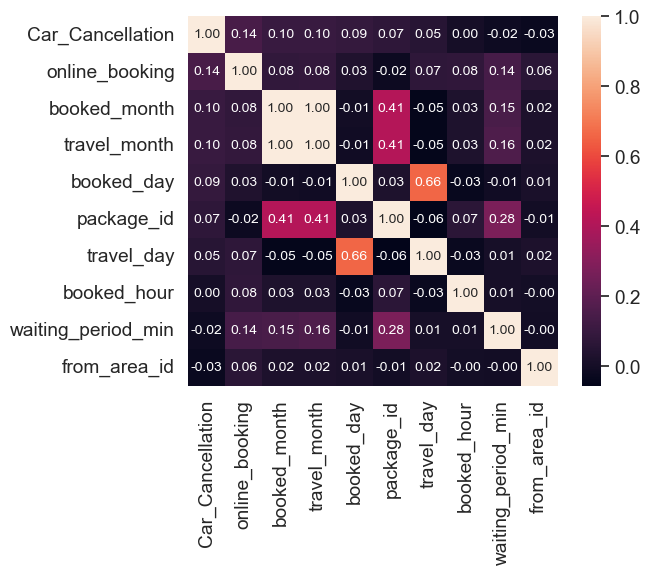

In [50]:
corrmat = data_tt3.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Car_Cancellation')['Car_Cancellation'].index
cm = np.corrcoef(data_tt3[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

###### NOTE : booked_month and travel_month are highly correlated, so dropping one of it (booked_month)

In [51]:
data_tt3 = data_tt3.drop(['booked_month'],axis=1)

### Extract features and target

In [52]:
x = data_tt3.iloc[:,data_tt3.columns != 'Car_Cancellation']
y = data_tt3.iloc[:,data_tt3.columns == 'Car_Cancellation']

### Scaling features before splitting

In [53]:
###Entire features scaling is required for some modelselections like KNN
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()

x_copy=x
x_ss=ss.fit_transform(x_copy)

y_copy=y.values.ravel()

### Split data into training and test data

In [54]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.25)

In [55]:
unique, counts = np.unique(ytrain, return_counts=True)
result_dict = dict(zip(unique, counts))

result_dict

{0: 5401, 1: 251}

#### y_train has severe improportion in the data so using over sampling technique

In [56]:
np.random.seed(42)
#from imblearn.over_sampling import RandomOverSampler
#over=RandomOverSampler()
#x_train_over, y_train_over = over.fit_resample(xtrain, ytrain)
#ytrain=y_train_over

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
x_train_over, y_train_over = sm.fit_resample(xtrain, ytrain)
ytrain=y_train_over

In [57]:
print(y_train_over.value_counts())

print(x_train_over.shape)
print(y_train_over.shape)

Car_Cancellation
0                   5401
1                   5401
dtype: int64
(10802, 10)
(10802, 1)


### Feature Scaling

#### Standard Scaler

In [58]:
from sklearn.preprocessing import StandardScaler
standard_Scaler=StandardScaler()
xtrain_ss = standard_Scaler.fit_transform(x_train_over)
xtest_ss = standard_Scaler.transform(xtest)

#### MinMax Scaler

In [59]:
from sklearn.preprocessing import MinMaxScaler
minmax_Scaler=MinMaxScaler()
xtrain_mm = minmax_Scaler.fit_transform(x_train_over)
xtest_mm = minmax_Scaler.transform(xtest)

In [60]:
ytrain=ytrain.values.ravel()

In [61]:
models_res=[]

In [62]:
np.random.seed(30)

### SVM Model

In [85]:
start=time.time()

from sklearn.svm import SVC

svm=SVC()

## Hyper_parameter optimisation using Grid Search CV
def svm_model_gridsearch(xtrain,ytrain):
    # Define the hyperparameter grid
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf','poly','linear']}
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', verbose=0,cv=5)
    grid_search.fit(xtrain,ytrain)
    return grid_search.best_params_

def svm_model(xtrain,xtest,ytrain):
    best_params = svm_model_gridsearch(xtrain,ytrain)
    best_svm = SVC(**best_params, probability=True)
    best_svm.fit(xtrain, ytrain)
    y_predict=best_svm.predict(xtest)
    y_predictproba=best_svm.predict_proba(xtest)[::,1]
    return [y_predict,y_predictproba,best_params]

def svm_model_metrices(ytest,ypredict):
    con_matrix=confusion_matrix(ytest,ypredict)
    accur=accuracy_score(ytest,ypredict)
    classf_report=classification_report(ytest,ypredict)
    f1_scr=f1_score(ytest,ypredict)
    return [con_matrix,accur,classf_report,f1_scr]

#### SVM model evaluation with Standard Scaled features

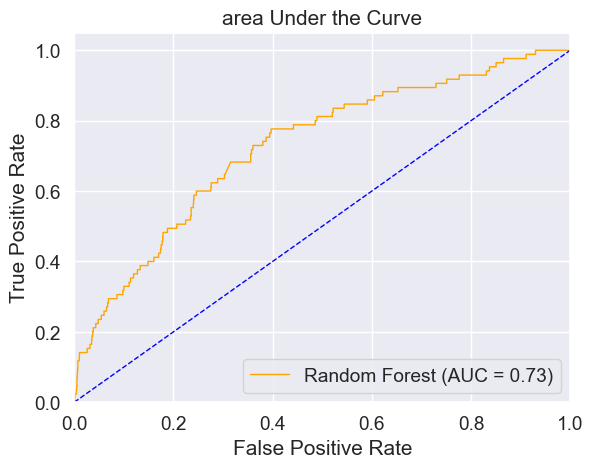

accuracy=  {0.6422505307855626} 

confusion_matrix= 
 [[1148  651]
 [  23   62]] 

classification report= 
               precision    recall  f1-score   support

           0       0.98      0.64      0.77      1799
           1       0.09      0.73      0.16        85

    accuracy                           0.64      1884
   macro avg       0.53      0.68      0.46      1884
weighted avg       0.94      0.64      0.75      1884

f1 score =  0.15538847117794485


In [86]:
y=svm_model(xtrain_ss,xtest_ss,ytrain)

svm_metrices=svm_model_metrices(ytest,y[0])
end=time.time()

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])
roc_auc_val = auc(fpr,tpr)

### Plotting ROC
plt.figure(1)
lw=1
plt.plot(fpr,tpr,color='orange',lw=lw,label='Random Forest (AUC = %0.2f)'%roc_auc_val)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
plt.legend(loc="lower right")
plt.show()

### Printing metrices
print(f'accuracy= ',{svm_metrices[1]},'\n')
print(f'confusion_matrix= \n',svm_metrices[0],'\n')
print(f'classification report= \n',svm_metrices[2])
print(f'f1 score = ',svm_metrices[3])
time_taken=end-start

models_res.append(['SVM - Standard Scaled',svm_metrices[1],auc,svm_metrices[3],time_taken,y[2]])